# Stochastic dual dynamic programming using SDDP.jl

This is an introductory tutorial to solving multistage stochastic optimization problems using SDDP.jl.

You can find more detailed tutorials at https://odow.github.io/SDDP.jl/latest/index.html. There are also lots of examples at https://github.com/odow/SDDP.jl.

## Installation 
First, we need to install SDDP.jl.

Unfortunately, this is somewhat confusing at the moment.

### Use juliabox.com

If you're on JuliaBox, things are tricky because the package management can't be done from the command line:
- Go to https://juliabox.com
- Sign-in using whatever SSO you prefer
- Click the "Package Builder (0.6)" in the bottom left
- Click the "Yours" tab
- In the "Unregistered Packages" type "https://github.com/odow/SDDP.jl", then click the "+"
- Scroll to the bottom and click "Start." This will rebuild an docker container with SDDP.jl. It may take a while.
- Now click "Launch." A Jupyter server will start.
- Upload this notebook, then open it.

### Local installation

You can also install Julia locally. Unfortunately, Julia recently upgraded from Julia v0.6 to v1.0, and SDDP.jl hasn't been upgraded yet. So, you need Julia v0.6.4 from https://julialang.org/downloads/oldreleases.html.

Once it is installed, open up the Julia command line and type
 - `Pkg.clone("https://github.com/odow/SDDP.jl")`
 - `Pkg.add("IJulia")` If prompted, you may also need to run `Pkg.build("IJulia")`
 These two steps can take a long time! Go and get a cup of coffee. 
 
Once everything is installed, download this notebook and save it somewheren. Then, open a new Julia command line and type
```julia
julia> using IJulia

julia> notebook("path/to/folder/where/you/saved/notebook")
```
This should start a Jupyter server in that directory, and you should be able to launch this notebook locally!

# A brief(!) introduction to JuMP

JuMP is an algebraic modelling language (AML) for Julia. It is similar to other AML's like GAMS, AMPL, PuLP, or Pyomo.

In Julia we load packages with the 'using' command. Let's load JuMP.
(Note: this may take a while the first time because it has to compile some things.)

In [1]:
using JuMP

Now let's use JuMP to solve the simple LP
$$\begin{align}
\min\limits_{x,y}\quad & x + y\\
\text{subject to} \quad & 2x + y \ge 2 \\
& x,\;y \ge 0
\end{align}$$

First, we construct the model:

In [2]:
model = Model()
@variable(model, x >= 0)
@variable(model, y >= 0)
@constraint(model, 2x + y >= 2)
@objective(model, Min, x + y)

println(model)

Min x + y
Subject to
 2 x + y ≥ 2
 x ≥ 0
 y ≥ 0



To solve a JuMP model, we need to use a solver. These are provided in different packages. 
For example, the COIN-OR solver Clp is provided in `Clp.jl`. 

Luckily, when we installed `SDDP.jl`, we also installed `Clp.jl` as a dependency.

(To use a solver like Gurobi, we need to manually run `Pkg.add("Gurobi")`, or use the JuliaBox package manager.)

We set Clp as the solver for our JuMP model as follows:

In [3]:
using Clp
setsolver(model, ClpSolver())

Now let's solve the model and look at the results.

In [4]:
# Now let's solve a model.
status = solve(model)

# Note that the "$()" syntax interpolates the value of the expression inside the parentheses into the string.
println("The status is: $(status).")
println("The primal value of x is: $(getvalue(x)).")
println("The primal value of y is: $(getvalue(y)).")
println("The objective value is: $(getobjectivevalue(model)).")

The status is: Optimal.
The primal value of x is: 1.0.
The primal value of y is: 0.0.
The objective value is: 1.0.


If you're interested in learning more about JuMP, go checkout the documentation at http://www.juliaopt.org/JuMP.jl/0.18/quickstart.html.

# Hydrothermal scheduling

Hydrothermal scheduling is the most common application of stochastic dual dynamic programming. To illustrate some of the basic functionality of SDDP.jl, we implement a very simple model of the hydrothermal scheduling problem.

In this model, there are two generators: a thermal generator, and a hydro generator. The thermal generator has a short-run marginal cost of \\$50/MWh in the first stage, \\$100/MWh in the second stage, and \\$150/MWh in the third stage. The hydro generator has a short-run marginal cost of \\$0/MWh.

We consider the problem of scheduling the generation over three time periods in order to meet a known demand of 150 MWh in each period.

The hydro generator draws water from a reservoir which has a maximum capacity of 200 units. We assume that at the start of the first time period, the reservoir is full. In addition to the ability to generate electricity by passing water through the hydroelectric turbine, the hydro generator can also spill water down a spillway (bypassing the turbine) in order to prevent the water from over-topping the dam. We assume that there is no cost of spillage.

The objective of the optimization is to minimize the expected cost of generation over the three time periods.

In [5]:
using SDDP

In [6]:
deterministic_model = SDDPModel(
                  sense = :Min,
                 stages = 3,
                 solver = ClpSolver(),
        objective_bound = 0.0
                                        ) do subproblem, stage
    @state(subproblem, 0 <= outgoing_volume <= 200, incoming_volume == 200)
    @variables(subproblem, begin
        thermal_generation >= 0
        hydro_generation   >= 0
        hydro_spill        >= 0
     end)
    INFLOW = 50
    @constraints(subproblem, begin
        incoming_volume + INFLOW - hydro_generation - hydro_spill == outgoing_volume
        thermal_generation + hydro_generation == 150
    end)
    FUEL_COST = [50.0, 100.0, 150.0]
    @stageobjective(subproblem, FUEL_COST[stage] * thermal_generation)
end;

In [7]:
solve(deterministic_model, iteration_limit=4);

-------------------------------------------------------------------------------
                          SDDP.jl © Oscar Dowson, 2017-2018
-------------------------------------------------------------------------------
    Solver:
        Serial solver
    Model:
        Stages:         3
        States:         1
        Subproblems:    3
        Value Function: Default
-------------------------------------------------------------------------------
              Objective              |  Cut  Passes    Simulations   Total    
     Simulation       Bound   % Gap  |   #     Time     #    Time    Time     
-------------------------------------------------------------------------------


       15.000K         5.000K        |     1    1.1      0    0.0    1.1 
        5.000K         5.000K        |     2    1.1      0    0.0    1.3 
        5.000K         5.000K        |     3    1.1      0    0.0    1.3 
        5.000K         5.000K        |     4    1.1      0    0.0    1.3 
-------------------------------------------------------------------------------
    Other Statistics:
        Iterations:         4
        Termination Status: iteration_limit


In [8]:
risk_neutral_model = SDDPModel(
                  sense = :Min,
                 stages = 3,
                 solver = ClpSolver(),
        objective_bound = 0.0
                                        ) do subproblem, stage
    @state(subproblem, 0 <= outgoing_volume <= 200, incoming_volume == 200)
    @variables(subproblem, begin
        thermal_generation >= 0
        hydro_generation   >= 0
        hydro_spill        >= 0
     end)
    # =========================================================================
    # Instead of a constant term, INFLOW can now take the value 0, 10, ..., 100
    # with equal probability.
    @rhsnoise(subproblem, INFLOW = 0.0:10.0:100.0,
        incoming_volume + INFLOW - hydro_generation - hydro_spill == outgoing_volume
    )
    # =========================================================================
    @constraint(subproblem, thermal_generation + hydro_generation == 150)
    FUEL_COST = [50.0, 100.0, 150.0]
    @stageobjective(subproblem, FUEL_COST[stage] * thermal_generation)
end;

In [9]:
srand(123)

solve(risk_neutral_model, iteration_limit=15,
    simulation = MonteCarloSimulation(
        frequency  = 5,
        max = 500
    )
);

-------------------------------------------------------------------------------
                          SDDP.jl © Oscar Dowson, 2017-2018
-------------------------------------------------------------------------------
    Solver:
        Serial solver
    Model:
        Stages:         3
        States:         1
        Subproblems:    3
        Value Function: Default
-------------------------------------------------------------------------------
              Objective              |  Cut  Passes    Simulations   Total    
     Simulation       Bound   % Gap  |   #     Time     #    Time    Time     
-------------------------------------------------------------------------------
        6.000K         5.000K        |     1    0.0      0    0.0    0.0 
       11.500K         7.430K        |     2    0.0      0    0.0    0.0 
        6.000K         7.430K        |     3    0.0      0    0.0    0.0 
        6.500K         7.512K        |     4    0.0      0    0.0    0.0 
   7.536K  

In [10]:
risk_averse_model = SDDPModel(
                  sense = :Min,
                 stages = 3,
                 solver = ClpSolver(),
        objective_bound = 0.0,
    # ========================================================================
           risk_measure = 0.5 * Expectation() + 0.5 * AVaR(1/3)
    # ========================================================================
                                        ) do subproblem, stage
    @state(subproblem, 0 <= outgoing_volume <= 200, incoming_volume == 200)
    @variables(subproblem, begin
        thermal_generation >= 0
        hydro_generation   >= 0
        hydro_spill        >= 0
     end)
    @rhsnoise(subproblem, INFLOW = 0.0:10.0:100.0,
        incoming_volume + INFLOW - hydro_generation - hydro_spill == outgoing_volume
    )
    @constraint(subproblem, thermal_generation + hydro_generation == 150)
    FUEL_COST = [50.0, 100.0, 150.0]
    @stageobjective(subproblem, FUEL_COST[stage] * thermal_generation)
end;

In [11]:
srand(123)

solve(risk_averse_model, iteration_limit=15,
    simulation = MonteCarloSimulation(
        frequency  = 5,
        max = 500
    )
);

-------------------------------------------------------------------------------
                          SDDP.jl © Oscar Dowson, 2017-2018
-------------------------------------------------------------------------------
    Solver:
        Serial solver
    Model:
        Stages:         3
        States:         1
        Subproblems:    3
        Value Function: Default
-------------------------------------------------------------------------------
              Objective              |  Cut  Passes    Simulations   Total    
     Simulation       Bound   % Gap  |   #     Time     #    Time    Time     
-------------------------------------------------------------------------------
        6.000K         8.636K        |     1    0.4      0    0.0    0.4 
       13.318K        10.500K        |     2    0.4      0    0.0    0.4 
        8.100K        10.543K        |     3    0.4      0    0.0    0.4 
       11.071K        10.554K        |     4    0.4      0    0.0    0.4 
   5.122K  

In [12]:
srand(1234)

risk_neutral_results = simulate(risk_neutral_model, 10_000, 
    [:thermal_generation, :hydro_generation, :outgoing_volume]
)

# Reset the seed so that we simulate the same scenarios.
srand(1234)

risk_averse_results = simulate(risk_averse_model, 10_000, 
    [:thermal_generation, :hydro_generation, :outgoing_volume]
);

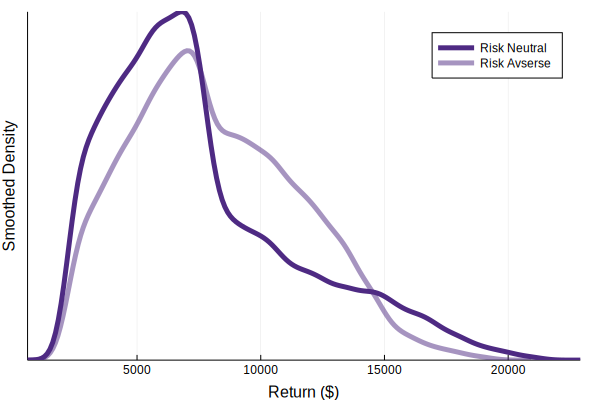

In [13]:
using Plots, StatPlots

plot(yticks = false, xlabel = "Return (\$)", ylabel = "Smoothed Density")

density!([r[:objective] for r in risk_neutral_results], 
    label = "Risk Neutral", width = 5, color = "#4e2a84"
)
density!([r[:objective] for r in risk_averse_results], 
    label = "Risk Avserse", width = 5, color = "#4e2a84", alpha = 0.5
)

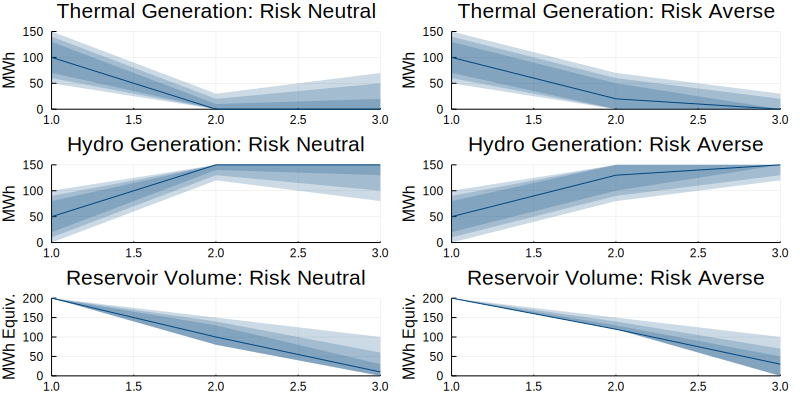

In [14]:
plot(
    SDDP.publicationplot(risk_neutral_results, :thermal_generation, 
        title = "Thermal Generation: Risk Neutral", ylabel = "MWh"),
    SDDP.publicationplot(risk_averse_results, :thermal_generation, 
        title = "Thermal Generation: Risk Averse", ylabel = "MWh"),
    
    SDDP.publicationplot(risk_neutral_results, :hydro_generation, 
        title = "Hydro Generation: Risk Neutral", ylabel = "MWh"),
    SDDP.publicationplot(risk_averse_results, :hydro_generation, 
        title = "Hydro Generation: Risk Averse", ylabel = "MWh"),

    SDDP.publicationplot(risk_neutral_results, :outgoing_volume, 
        title = "Reservoir Volume: Risk Neutral", ylabel="MWh Equiv."),
    SDDP.publicationplot(risk_averse_results, :outgoing_volume, 
        title = "Reservoir Volume: Risk Averse", ylabel="MWh Equiv."),
    layout = (3, 2),
    size = (800, 400)
)